In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from datasets import DSBDataset
import transforms as segtrans
import numpy as np
from utils.visualize import display_boxes
import torch
from torch.autograd import Variable
from models import RetinaNet, FPN50 
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader
from utils.object_detection import AnchorHelper
from criterion import FocalLoss

In [2]:
ROOT = '/home/austin/data/dsb/train'

In [3]:
transforms = segtrans.JointCompose([segtrans.Resize(300),
                                    segtrans.RandomRotate(0, 90),
                                    segtrans.RandomCrop(256, 256),
                                    segtrans.ToTensor()], instance_masks=True)

In [4]:
dataset = DSBDataset(ROOT, transforms, merge_masks=False)

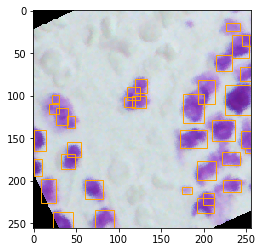

In [5]:
image, gt_boxes = dataset[2]
display_boxes(image.permute(1, 2, 0), gt_boxes)

In [6]:
anchor_helper = AnchorHelper(areas=(16, 32, 64, 128, 256),
                            positive_overlap=0.5,
                            negative_overlap=0.3)

In [7]:
labels, assigned_boxes, anchors = anchor_helper.assign_gt_boxes(image, gt_boxes)

In [8]:
labels[labels==1].shape

(166,)

## Assigned boxes

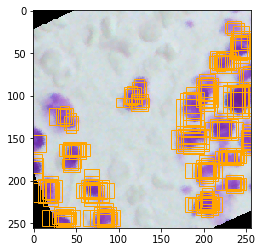

In [9]:
display_boxes(image.permute(1, 2, 0), anchors[labels==1])

## Ignored boxes (out of the image or between pos and neg overlap)

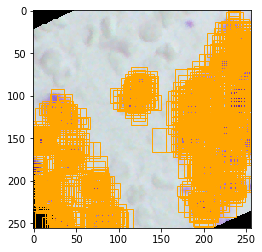

In [10]:
display_boxes(image.permute(1, 2, 0), anchors[labels==-1])

## Background Boxes

In [11]:
anchors[labels==0].shape

(11171, 4)

In [12]:
class_labels, anchor_deltas = anchor_helper.make_targets(image, gt_boxes)

In [13]:
dataset = DSBDataset(ROOT, transforms, merge_masks=False, anchor_helper=anchor_helper)

In [14]:
retinanet = RetinaNet(num_classes=2)

In [15]:
optimizer = Adam(retinanet.parameters(), lr=1e-5)
focal_loss = FocalLoss(gamma=2, alpha=1e3, ignore_index=-1)
loader = DataLoader(dataset, batch_size=4)

In [16]:
retinanet.cuda()
retinanet.train();

In [17]:
for i, (images, class_labels, anchor_deltas) in enumerate(loader):
    images = Variable(images).cuda()
    class_labels = Variable(class_labels).cuda()
    anchor_deltas = Variable(anchor_deltas).cuda()
    
    class_preds, box_preds = retinanet(images)
    class_loss = focal_loss(class_preds, class_labels)
    box_loss = F.smooth_l1_loss(box_preds, anchor_deltas)
    loss = class_loss + box_loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print('cls_loss', class_loss.data[0])
    print('box_loss', box_loss.data[0])

cls_loss 2.3178510665893555
box_loss 1.4625016450881958
cls_loss 0.858533501625061
box_loss 1.934279203414917
cls_loss 1.2657411098480225
box_loss 1.8402410745620728
cls_loss 1.2173653841018677
box_loss 2.2185940742492676
cls_loss 1.3896042108535767
box_loss 2.0296573638916016
cls_loss 1.1313420534133911
box_loss 1.7882388830184937
cls_loss 0.9501945972442627
box_loss 1.1317861080169678
cls_loss 1.2158467769622803
box_loss 1.289648175239563
cls_loss 1.3950285911560059
box_loss 2.187450885772705
cls_loss 1.6994351148605347
box_loss 0.8949567675590515
cls_loss 1.4635549783706665
box_loss 1.0379306077957153
cls_loss 0.6858910322189331
box_loss 1.887665033340454
cls_loss 1.6972177028656006
box_loss 1.519890546798706
cls_loss 1.39375638961792
box_loss 1.464117169380188
cls_loss 1.6615023612976074
box_loss 1.1242930889129639
cls_loss 0.9329589605331421
box_loss 1.7628041505813599
cls_loss 1.5964504480361938
box_loss 1.1924480199813843
cls_loss 2.160292387008667
box_loss 1.3164221048355103
cl

In [18]:
test_img, test_labels, test_deltas = dataset[0]

In [19]:
test_img


( 0 ,.,.) = 
  0.0157  0.0118  0.0118  ...   0.0000  0.0000  0.0000
  0.0235  0.0118  0.0196  ...   0.0000  0.0000  0.0000
  0.0706  0.0235  0.0353  ...   0.0000  0.0000  0.0000
           ...             ⋱             ...          
  0.0118  0.0118  0.0157  ...   0.0000  0.0000  0.0000
  0.0118  0.0118  0.0078  ...   0.0000  0.0000  0.0000
  0.0157  0.0118  0.0157  ...   0.0000  0.0000  0.0000

( 1 ,.,.) = 
  0.0157  0.0118  0.0118  ...   0.0000  0.0000  0.0000
  0.0235  0.0118  0.0196  ...   0.0000  0.0000  0.0000
  0.0706  0.0235  0.0353  ...   0.0000  0.0000  0.0000
           ...             ⋱             ...          
  0.0118  0.0118  0.0157  ...   0.0000  0.0000  0.0000
  0.0118  0.0118  0.0078  ...   0.0000  0.0000  0.0000
  0.0157  0.0118  0.0157  ...   0.0000  0.0000  0.0000

( 2 ,.,.) = 
  0.0157  0.0118  0.0118  ...   0.0000  0.0000  0.0000
  0.0235  0.0118  0.0196  ...   0.0000  0.0000  0.0000
  0.0706  0.0235  0.0353  ...   0.0000  0.0000  0.0000
           ...         

In [22]:
class_preds, box_preds = retinanet(Variable(test_img.unsqueeze(0)).cuda())

In [ ]:
targets = Variable(test_labels).cuda()

In [ ]:
targets

In [ ]:
F.cross_entropy(outputs, targets)

In [24]:
class_preds

Variable containing:
(  0  ,.,.) = 
   2.4568   0.0000
   0.0000   1.2926
   0.0000   1.2812
        ⋮         
   0.0000   2.0635
   0.0000   1.1699
   0.0000   1.3399
[torch.cuda.FloatTensor of size 1x12276x2 (GPU 0)]